In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # For progress bar

data_path = '/content/drive/My Drive/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection'
csv_file = os.path.join(data_path, 'train.csv')
print(csv_file)
# Define data augmentations

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection/train.csv


In [ ]:
class Aptos(Dataset):
  NUM_CLASSES = 5
  INPUT_SIZE = (224, 224)
  PATCH_SIZE = (16, 16)
  IN_CHANNELS = 3
  RANDOM_SEED = 0
  TRAIN_SPLIT_FRAC = 0.8

  def __init__(self, csv_file, root_dir):
      self.data_frame = pd.read_csv(csv_file)
      self.root_dir = root_dir
      self.transform = transforms.Compose([
        transforms.Resize(self.INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
       # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),])

  def __len__(self):
      return len(self.data_frame)

  def __getitem__(self, idx):
      img_name = os.path.join(self.root_dir, 'train_images', self.data_frame.iloc[idx, 0] + '.png')
      image = Image.open(img_name).convert('RGB')
      label = self.data_frame.iloc[idx, 1]

      if self.transform:
          image = self.transform(image)

      return image, label

'\n  def __init__(self, base_root: str, train: bool = True) -> None:\n    super(),__init__()\n    self.mode = "train" if train else "val"\n    imgs_file = "train_images"\n    annotations_file = "train.csv"\n    self.root = os.path.join(base_root, imgs_file)\n\n    if not os.path.isdir(self.root):\n      os.makedirs(self.root)\n    self.transforms = transforms.Compose(\n        [\n            transforms.Resize[self.INPUT_SIZE[0] - 1, max_size=self.INPUT_SIZE[0]],\n\n        ]\n    )\n\n    def __len__(self):\n        return len(self.img_labels)\n\n    def __getitem__(self, idx):\n      img_name = os.path.join(self.root_dir, \'train_images\', self.data_frame.iloc[idx, 0] + \'.png\')\n        image = Image.open(img_name).convert(\'RGB\')\n        label = self.data_frame.iloc[idx, 1]\n\n        if self.transform:\n            image = self.transform(image)\n\n        return image, label\n\n\n        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])\n        image = read_im

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


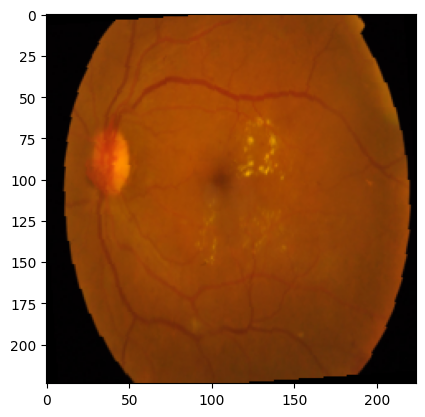

Label: 2


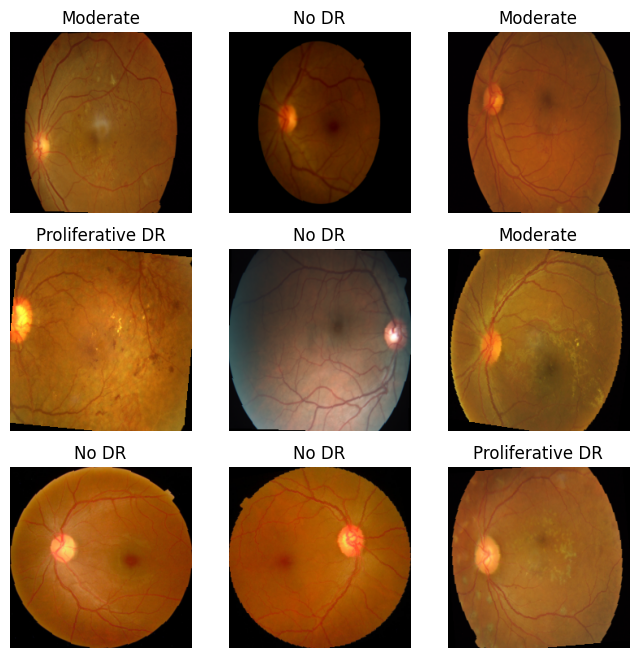

In [ ]:
import matplotlib.pyplot as plt

train_dataset = Aptos(csv_file=csv_file, root_dir=data_path)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img = img.permute(1, 2, 0)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

labels_map = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

In [ ]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Change the final layer to match the number of classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 129MB/s]


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # Set to a smaller number for quicker testing

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
      try:
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (i + 1))
            pbar.update(1)
      except:
          pass

print('Finished Training')



Epoch 5/10:   0%|          | 0/115 [00:00<?, ?batch/s]

In [ ]:
torch.save(model.state_dict(), 'diabetic_retinopathy_resnet_model.pth')


Further Reading
===============

-   [torch.utils.data API](https://pytorch.org/docs/stable/data.html)
